# Section 1 — Environment & GPU Sanity Check

In this section we make sure your environment can run the project reliably and fast:

- Report key versions (Python, PyTorch, TorchVision, CUDA build).
- Confirm that CUDA is available and your GPU is visible.
- Sanity-run a tiny CUDA workload to verify kernels execute.
- (Optional) Quick *determinism* smoke test so repeated runs are stable.

If anything fails here, fix it **before** training/benchmarking later sections.


In [1]:
# Must be the first cell you run (before importing torch)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

import sys, platform, json, shutil, subprocess
from pathlib import Path

# Try to import torch/torchvision and capture versions safely
try:
    import torch
    torch_ver = torch.__version__
    torch_cuda_build = getattr(torch.version, "cuda", None)
    cuda_avail = torch.cuda.is_available()
    cuda_count = torch.cuda.device_count()
    dev_name = torch.cuda.get_device_name(0) if cuda_avail else None
    dev_cap  = torch.cuda.get_device_capability(0) if cuda_avail else None
    cudnn_ver = torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else None
except Exception as e:
    torch, torch_ver, torch_cuda_build, cuda_avail, cuda_count, dev_name, dev_cap, cudnn_ver = (None,)*8
    print("[WARN] torch import failed:", e)

try:
    import torchvision
    tv_ver = torchvision.__version__
except Exception:
    tv_ver = None

info = {
    "python": sys.version.split()[0],
    "platform": f"{platform.system()} {platform.release()} ({platform.machine()})",
    "torch": torch_ver,
    "torchvision": tv_ver,
    "torch_cuda_build": torch_cuda_build,   # CUDA toolkit version PyTorch was built with
    "cuda_is_available": cuda_avail,
    "cuda_device_count": cuda_count,
    "cuda_device_name": dev_name,
    "cuda_device_capability": dev_cap,
    "cudnn_version": cudnn_ver,
}

# Optional: query driver with nvidia-smi if present
if shutil.which("nvidia-smi"):
    try:
        q = ["nvidia-smi",
             "--query-gpu=name,driver_version,cuda_version",
             "--format=csv,noheader"]
        result = subprocess.run(q, capture_output=True, text=True, check=True)
        info["nvidia_smi"] = result.stdout.strip().splitlines()
    except Exception as e:
        info["nvidia_smi"] = f"query failed: {e}"
else:
    info["nvidia_smi"] = "not found"

print(json.dumps(info, indent=2))


env: CUBLAS_WORKSPACE_CONFIG=:4096:8
{
  "python": "3.12.0",
  "platform": "Windows 11 (AMD64)",
  "torch": "2.9.0.dev20250905+cu128",
  "torchvision": "0.24.0.dev20250905+cu128",
  "torch_cuda_build": "12.8",
  "cuda_is_available": true,
  "cuda_device_count": 1,
  "cuda_device_name": "NVIDIA GeForce RTX 5070 Ti",
  "cuda_device_capability": [
    12,
    0
  ],
  "cudnn_version": 91002,
  "nvidia_smi": "query failed: Command '['nvidia-smi', '--query-gpu=name,driver_version,cuda_version', '--format=csv,noheader']' returned non-zero exit status 2."
}


In [2]:
import time, json
import torch

device = "cuda" if (torch.cuda.is_available()) else "cpu"

# Tiny matmul sanity & timing
def matmul_sanity(n=1024, dtype=torch.float16):
    x = torch.randn((n, n), device=device, dtype=dtype)
    y = torch.randn((n, n), device=device, dtype=dtype)
    # Warmup
    for _ in range(5):
        z = x @ y
        if device == "cuda":
            torch.cuda.synchronize()
    # Timed
    t0 = time.perf_counter()
    for _ in range(10):
        z = x @ y
    if device == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()
    return (t1 - t0) / 10.0  # sec/iter

# Try FP16 autocast on CUDA if available (falls back to FP32 otherwise)
if device == "cuda":
    with torch.amp.autocast("cuda", enabled=True):
        sec = matmul_sanity()
else:
    sec = matmul_sanity(dtype=torch.float32)

print(json.dumps({
  "device": device,
  "avg_sec_per_iter": round(sec, 6)
}, indent=2))


{
  "device": "cuda",
  "avg_sec_per_iter": 3e-05
}


In [4]:
# Optional Determinism Smoke Test (GPU if possible, else CPU)
import os, hashlib, torch, random
from torch import nn

USE_GPU = torch.cuda.is_available() and os.environ.get("CUBLAS_WORKSPACE_CONFIG") in (":4096:8", ":16:8")
device  = "cuda" if USE_GPU else "cpu"

def set_deterministic(seed=42):
    # Only helps if set before CUDA/cuBLAS is used; we still set it here for completeness
    if device == "cuda":
        # NOTE: For strict GPU determinism, ensure you set this in the FIRST cell and restart the kernel:
        # %env CUBLAS_WORKSPACE_CONFIG=:4096:8
        os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def model_hash(m: nn.Module):
    h = hashlib.sha256()
    with torch.no_grad():
        for p in m.parameters():
            h.update(p.detach().cpu().contiguous().numpy().tobytes())
    return h.hexdigest()

def train_synthetic(seed=1234, steps=100):
    set_deterministic(seed)
    if device == "cuda":
        torch.cuda.empty_cache()
    model = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(32, 10)
    ).to(device)

    opt = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
    for _ in range(steps):
        x = torch.randn(64, 3, 32, 32, device=device)
        y = torch.randint(0, 10, (64,), device=device)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = nn.functional.cross_entropy(logits, y)
        loss.backward(); opt.step()
    return model_hash(model)

try:
    h1 = train_synthetic()
    h2 = train_synthetic()
    print({
        "device": device,
        "deterministic_equal": h1 == h2,
        "hash1_prefix": h1[:12],
        "hash2_prefix": h2[:12]
    })
except RuntimeError as e:
    # If GPU determinism is not properly configured, auto-fallback to CPU
    print("[WARN] GPU deterministic test failed; falling back to CPU. Error:", str(e).splitlines()[0])
    device = "cpu"
    h1 = train_synthetic()
    h2 = train_synthetic()
    print({
        "device": device,
        "deterministic_equal": h1 == h2,
        "hash1_prefix": h1[:12],
        "hash2_prefix": h2[:12]
    })


{'device': 'cuda', 'deterministic_equal': True, 'hash1_prefix': '1464b87f9069', 'hash2_prefix': '1464b87f9069'}


**If CUDA is not available or errors out:**
- Ensure your NVIDIA driver is recent enough for your PyTorch build.
- Reinstall a matching PyTorch build: https://pytorch.org/get-started/locally/
- Close GPU-hungry apps (browsers with many tabs, game overlays, etc.).

**If determinism test fails:**
- It’s optional. You’ll still get stable *benchmarks* by:
  - Fixing seeds during training (we do this later),
  - Disabling `cudnn.benchmark`,
  - Pinning CPU threads for benches,
  - Using larger warmup/repeat counts.

You’re good to proceed to **Section 2 (Data download)** once the CUDA sanity cell runs without error.


# Section 2 — Data (idempotent)

Goal: make sure the dataset is present and usable for the rest of the pipeline.

- **Dataset:** CIFAR-10 (50k train / 10k test, 32×32 RGB, 10 classes).
- **Why:** small, standard, fast to iterate; perfect to demonstrate pruning/quantization trade-offs.
- **Idempotent:** Re-running this section is safe — it won’t re-download if data already exists.
- **What we’ll do:**
  1. Try to run the project helper: `scripts/download_data.py --dataset cifar10 --out data/`.
  2. If the helper script is missing/unavailable, fall back to `torchvision.datasets.CIFAR10(download=True)`.
  3. Verify integrity by loading train/test, printing sizes and class names.
  4. Show a small image grid to visually confirm samples/labels.
  5. Write a tiny `outputs/data_manifest.json` with summary info.


In [8]:
from pathlib import Path
import json, time, sys, os

# --- Config (edit if needed) ---
DATASET  = "cifar10"
DATA_DIR = Path("data")          # where the dataset will live
OUT_DIR  = Path("outputs")       # where we’ll write a small manifest
# --------------------------------

DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print({
    "dataset": DATASET,
    "data_dir": str(DATA_DIR.resolve()),
    "outputs_dir": str(OUT_DIR.resolve())
})


{'dataset': 'cifar10', 'data_dir': 'C:\\Users\\khal6952\\Documents\\GitHub\\compact-ml-bench\\data', 'outputs_dir': 'C:\\Users\\khal6952\\Documents\\GitHub\\compact-ml-bench\\outputs'}


In [9]:
import subprocess
from pathlib import Path

def ensure_dataset(dataset: str, data_dir: Path):
    """
    Tries the project helper script first:
        python scripts/download_data.py --dataset <name> --out <dir>
    Falls back to torchvision download if the script is unavailable.
    """
    helper = Path("scripts/download_data.py")
    if helper.exists():
        print(f"[DATA] Using project helper: {helper}")
        cmd = [sys.executable, str(helper), "--dataset", dataset, "--out", str(data_dir)]
        try:
            subprocess.run(cmd, check=True)
            return True, "helper"
        except subprocess.CalledProcessError as e:
            print(f"[WARN] Helper script failed ({e}). Falling back to torchvision…")
    else:
        print("[DATA] Helper script not found. Falling back to torchvision…")

    # Fallback: torchvision
    try:
        import torchvision
        from torchvision import datasets, transforms
        _ = datasets.CIFAR10(root=str(data_dir), train=True,  download=True)
        _ = datasets.CIFAR10(root=str(data_dir), train=False, download=True)
        return True, "torchvision"
    except Exception as e:
        print("[ERROR] torchvision fallback failed:", e)
        return False, "error"

ok, how = ensure_dataset(DATASET, DATA_DIR)
print({"ok": ok, "how": how})
if not ok:
    raise SystemExit("[FATAL] Dataset step failed. Fix network or permissions and re-run this cell.")


[DATA] Using project helper: scripts\download_data.py
{'ok': True, 'how': 'helper'}


{'train_len': 50000, 'test_len': 10000, 'classes': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']}


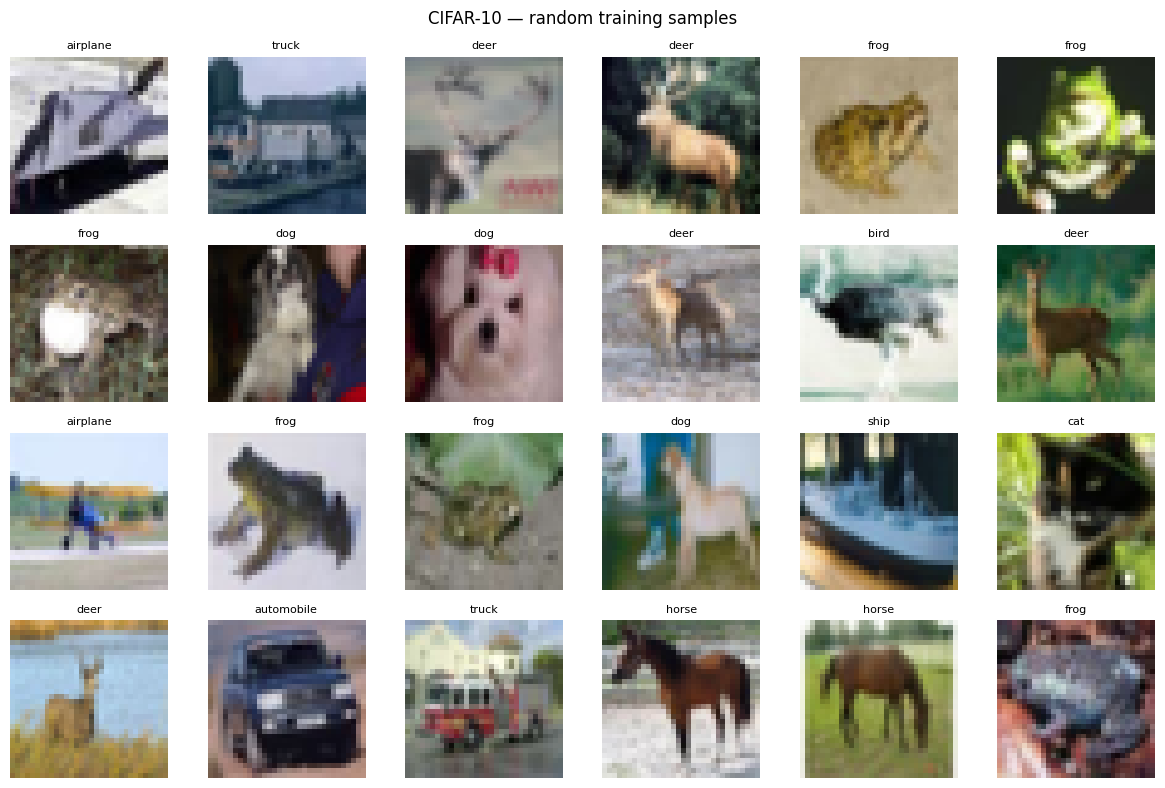

In [10]:
import random
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# CIFAR-10 mean/std we use later in training
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

t_plain = transforms.ToTensor()
train_ds = datasets.CIFAR10(root=str(DATA_DIR), train=True, download=False, transform=t_plain)
test_ds  = datasets.CIFAR10(root=str(DATA_DIR), train=False, download=False, transform=t_plain)

print({
    "train_len": len(train_ds),   # expect 50000
    "test_len":  len(test_ds),    # expect 10000
    "classes":   train_ds.classes
})

# --- Show a small grid (random 4x6) ---
N_ROWS, N_COLS = 4, 6
idxs = random.sample(range(len(train_ds)), N_ROWS*N_COLS)
fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS*2.0, N_ROWS*2.0))
for ax, i in zip(axes.flatten(), idxs):
    img, label = train_ds[i]
    # img is 0..1 in CHW, convert to HWC for imshow
    ax.imshow(img.permute(1,2,0))
    ax.set_title(train_ds.classes[label], fontsize=8)
    ax.axis("off")

plt.suptitle("CIFAR-10 — random training samples", y=0.98)
plt.tight_layout()
plt.show()


In [11]:
import os, time, json
from pathlib import Path

# Heuristic: sum of files in CIFAR-10 directory (for quick sanity)
def dir_size_mb(path: Path) -> float:
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            try:
                total += (Path(root) / f).stat().st_size
            except OSError:
                pass
    return round(total / (1024*1024), 2)

manifest = {
    "dataset": DATASET,
    "data_dir": str(DATA_DIR),
    "train_len": len(train_ds),
    "test_len": len(test_ds),
    "classes": train_ds.classes,
    "disk_usage_mb": dir_size_mb(DATA_DIR / "cifar-10-batches-py"),
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
}

out_path = OUT_DIR / "data_manifest.json"
with open(out_path, "w") as f:
    json.dump(manifest, f, indent=2)

print(f"[DATA] Wrote manifest -> {out_path.resolve()}")
print(json.dumps(manifest, indent=2))


[DATA] Wrote manifest -> C:\Users\khal6952\Documents\GitHub\compact-ml-bench\outputs\data_manifest.json
{
  "dataset": "cifar10",
  "data_dir": "data",
  "train_len": 50000,
  "test_len": 10000,
  "classes": [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
  ],
  "disk_usage_mb": 177.59,
  "timestamp": "2025-09-05 22:18:23"
}


✅ Data ready.

Proceed to **Section 3 — Baseline training**:
- We’ll train ResNet-18 on CIFAR-10 with fixed seeds and show live progress.
- Then we’ll benchmark latency on GPU/CPU and record the numbers.


# Section 3 — Train the baseline model

**Goal:** Train a strong-but-compact baseline on CIFAR-10 that we can later prune and benchmark.

- **Model:** `ResNet18` (good accuracy/size balance)
- **Dataset:** CIFAR-10 (already prepared in Section 2)
- **Outputs:** `runs/<OutBase>/best.pt` (checkpoint with highest accuracy)
- **Notes:** We call the project’s training script so the notebook stays lightweight and consistent with the CLI workflow.
- **Live logs:** We stream the process output so you see epochs, accuracy, and ETA in real time.


In [12]:
import os, sys, json, time
from pathlib import Path

# ---- Config ----
MODEL    = "resnet18"   # or "resnet34", "mobilenet_v2" (if supported by your scripts)
EPOCHS   = 40
BATCH    = 1024         # adjust to your GPU VRAM; 1024 is safe on 16 GB VRAM for CIFAR-10
WORKERS  = 16           # your 32-thread CPU can handle this
SEED     = 42
OUTBASE  = "baseline_40e"   # run folder name under runs/
DATASET  = "cifar10"
DATA_DIR = Path("data")

print({
    "model": MODEL,
    "epochs": EPOCHS,
    "batch": BATCH,
    "workers": WORKERS,
    "seed": SEED,
    "out_dir": f"runs/{OUTBASE}",
    "data_dir": str(DATA_DIR.resolve())
})


{'model': 'resnet18', 'epochs': 40, 'batch': 1024, 'workers': 16, 'seed': 42, 'out_dir': 'runs/baseline_40e', 'data_dir': 'C:\\Users\\khal6952\\Documents\\GitHub\\compact-ml-bench\\data'}


In [14]:
import subprocess, shlex, sys, time, os
from pathlib import Path

train_script = Path("scripts/train.py")
assert train_script.exists(), "scripts/train.py not found."

cmd = [
    sys.executable, "-u", str(train_script),
    "--model", MODEL,
    "--epochs", str(EPOCHS),
    "--batch-size", str(BATCH),
    "--seed", str(SEED),
    "--num-workers", str(WORKERS),
    "--out", f"runs/{OUTBASE}",
    "--data", str(DATA_DIR)
]

print("[TRAIN] Launching:", " ".join(shlex.quote(c) for c in cmd))

# Force UTF-8 from the child process
env = os.environ.copy()
env["PYTHONIOENCODING"] = "utf-8"

start = time.time()
proc = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,                 # get str lines
    encoding="utf-8",          # decode as UTF-8
    errors="replace",          # replace any bad bytes instead of crashing
    bufsize=1,
    env=env
)

for line in proc.stdout:
    print(line, end="")
ret = proc.wait()
elapsed = time.time() - start
print(f"\n[TRAIN] Exit code: {ret} | Elapsed: {elapsed:.1f}s")
if ret != 0:
    raise SystemExit("[FATAL] Training failed.")


[TRAIN] Launching: 'c:\Users\khal6952\Documents\GitHub\compact-ml-bench\.venv\Scripts\python.exe' -u 'scripts\train.py' --model resnet18 --epochs 40 --batch-size 1024 --seed 42 --num-workers 16 --out runs/baseline_40e --data data

Epoch 1/40:  84%|████████▎ | 41/49 [00:32<00:02,  3.42it/s, loss=1.851, lr=0.1000]
                                                                                  
[EPOCH 01] acc=31.02% | epoch_time=00:00:32 | ETA_total=00:21:11

Epoch 2/40: 100%|██████████| 49/49 [00:00<00:00, 76.76it/s, loss=1.630, lr=0.0998]
                                                                                  
[EPOCH 02] acc=40.66% | epoch_time=00:00:00 | ETA_total=00:10:37

Epoch 3/40:  84%|████████▎ | 41/49 [00:00<00:00, 71.78it/s, loss=1.526, lr=0.0994]
                                                                                  
[EPOCH 03] acc=46.33% | epoch_time=00:00:00 | ETA_total=00:07:04

Epoch 4/40:  86%|████████▌ | 42/49 [00:00<00:00, 72.49it/s, loss=1.357, l

In [15]:
import os, json, torch
from pathlib import Path

ckpt_path = Path(f"runs/{OUTBASE}/best.pt")
assert ckpt_path.exists(), f"Missing checkpoint: {ckpt_path}."

# Try safe load (PyTorch >= 2.4); fallback for older weights
try:
    ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=True)
except TypeError:
    ckpt = torch.load(ckpt_path, map_location="cpu")

# Extract state_dict + meta if present
if isinstance(ckpt, dict) and "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]
    meta = ckpt.get("meta", {})
else:
    state_dict, meta = ckpt, {}

# Param count from state_dict
import itertools
num_params = sum(p.numel() for _, p in state_dict.items())
params_m = round(num_params / 1e6, 3)

# File size
size_mb = round(ckpt_path.stat().st_size / (1024*1024), 3)

summary = {
    "checkpoint": str(ckpt_path),
    "model": meta.get("model_name", MODEL),
    "params_millions": params_m,
    "size_mb": size_mb,
    "epochs": EPOCHS,
    "batch_size": BATCH,
    "seed": SEED
}
print("[TRAIN] Artifact summary:")
print(json.dumps(summary, indent=2))


[TRAIN] Artifact summary:
{
  "checkpoint": "runs\\baseline_40e\\best.pt",
  "model": "resnet18",
  "params_millions": 11.191,
  "size_mb": 42.724,
  "epochs": 40,
  "batch_size": 1024,
  "seed": 42
}


✅ Baseline training complete and `best.pt` is present.

Next: **Section 4 — Benchmark baseline latency (GPU/CPU)**  
We’ll measure ms/sample with warmup and repeated runs, then log a JSON that we’ll use to build comparison plots later.


# Section 4 — Benchmark the baseline (GPU & CPU)

**Goal:** Measure latency (ms / sample) for the trained baseline on both GPU and CPU.

**Method (consistent with project CLI):**
- Use `scripts/bench.py` with:
  - **Warmup** iterations: ignored in stats (warms caches/JIT).
  - **Repeat** iterations: timed and averaged.
- **GPU run:** default device `cuda` (if available).
- **CPU run:** pin to a single thread (`threads=1`) and set `MKL_NUM_THREADS=1`, `OMP_NUM_THREADS=1` to reduce noise.

**Outputs:**
- `outputs/bench_<OutBase>_gpu.json`
- `outputs/bench_<OutBase>_cpu.json`
- Each JSON contains: device, latency_ms_b1, params_millions, model_size_mb.


In [16]:
import os, sys
from pathlib import Path

# Reuse config from Section 3 if already defined; else set defaults
try:
    OUTBASE
except NameError:
    OUTBASE = "baseline_40e"

WARMUP  = 60   # tweak if needed
REPEAT  = 600  # tweak if needed
CKPT    = Path(f"runs/{OUTBASE}/best.pt")
OUTS    = Path("outputs")
OUTS.mkdir(parents=True, exist_ok=True)

assert CKPT.exists(), f"Checkpoint not found: {CKPT} — run Section 3 first."

print({
    "checkpoint": str(CKPT),
    "warmup": WARMUP,
    "repeat": REPEAT,
    "gpu_out": str(OUTS / f"bench_{OUTBASE}_gpu.json"),
    "cpu_out": str(OUTS / f"bench_{OUTBASE}_cpu.json")
})


{'checkpoint': 'runs\\baseline_40e\\best.pt', 'warmup': 60, 'repeat': 600, 'gpu_out': 'outputs\\bench_baseline_40e_gpu.json', 'cpu_out': 'outputs\\bench_baseline_40e_cpu.json'}


In [17]:
import subprocess, shlex, time, json

def run_bench_eager(checkpoint: Path, device: str, warmup: int, repeat: int, out_path: Path, threads: int|None=None, verbose: int=1):
    bench = Path("scripts/bench.py")
    assert bench.exists(), "scripts/bench.py not found."

    cmd = [sys.executable, "-u", str(bench),
           "--checkpoint", str(checkpoint),
           "--device", device,
           "--warmup", str(warmup),
           "--repeat", str(repeat),
           "--verbose", str(verbose),
           "--out", str(out_path)]
    if threads is not None:
        cmd += ["--threads", str(threads)]

    env = os.environ.copy()
    # Stabilize CPU runs if requested
    if device == "cpu":
        env["MKL_NUM_THREADS"] = env.get("MKL_NUM_THREADS", "1")
        env["OMP_NUM_THREADS"] = env.get("OMP_NUM_THREADS", "1")
    # Make text decoding robust on Windows terminals
    env["PYTHONIOENCODING"] = "utf-8"

    print("[BENCH] Launching:", " ".join(shlex.quote(c) for c in cmd))
    t0 = time.time()
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                            text=True, encoding="utf-8", errors="replace", bufsize=1, env=env)
    for line in proc.stdout:
        print(line, end="")
    ret = proc.wait()
    dt  = time.time() - t0
    print(f"[BENCH] Exit code={ret} | Elapsed={dt:.1f}s")
    if ret != 0:
        raise SystemExit(f"[FATAL] bench.py failed on device={device}")

    with open(out_path, "r", encoding="utf-8") as f:
        return json.load(f)

gpu_json = OUTS / f"bench_{OUTBASE}_gpu.json"

# If CUDA isn't available, we’ll skip gracefully
try:
    import torch
    if torch.cuda.is_available():
        gpu_result = run_bench_eager(CKPT, "gpu", WARMUP, REPEAT, gpu_json, threads=None, verbose=1)
        print("[GPU] Result:", gpu_result)
    else:
        gpu_result = None
        print("[GPU] CUDA not available — skipping GPU benchmark.")
except Exception as e:
    gpu_result = None
    print("[GPU] Benchmark skipped due to error:", e)


[BENCH] Launching: 'c:\Users\khal6952\Documents\GitHub\compact-ml-bench\.venv\Scripts\python.exe' -u 'scripts\bench.py' --checkpoint 'runs\baseline_40e\best.pt' --device gpu --warmup 60 --repeat 600 --verbose 1 --out 'outputs\bench_baseline_40e_gpu.json'
[BENCH] start
[BENCH] requested=gpu -> using device=cuda
[BENCH] loading checkpoint: runs\baseline_40e\best.pt
[BENCH] meta={'model_name': 'resnet18', 'num_classes': 10}
[BENCH] wrote outputs\bench_baseline_40e_gpu.json
{
  "device": "cuda",
  "latency_ms_b1": 0.987,
  "params_millions": 11.182,
  "model_size_mb": 42.724,
  "threads": null
}
[BENCH] done
[BENCH] Exit code=0 | Elapsed=2.8s
[GPU] Result: {'device': 'cuda', 'latency_ms_b1': 0.987, 'params_millions': 11.182, 'model_size_mb': 42.724, 'threads': None}


In [18]:
cpu_json = OUTS / f"bench_{OUTBASE}_cpu.json"
cpu_result = run_bench_eager(CKPT, "cpu", WARMUP, REPEAT, cpu_json, threads=1, verbose=1)
print("[CPU] Result:", cpu_result)


[BENCH] Launching: 'c:\Users\khal6952\Documents\GitHub\compact-ml-bench\.venv\Scripts\python.exe' -u 'scripts\bench.py' --checkpoint 'runs\baseline_40e\best.pt' --device cpu --warmup 60 --repeat 600 --verbose 1 --out 'outputs\bench_baseline_40e_cpu.json' --threads 1
[BENCH] start
[BENCH] requested=cpu -> using device=cpu
[BENCH] loading checkpoint: runs\baseline_40e\best.pt
[BENCH] meta={'model_name': 'resnet18', 'num_classes': 10}
[BENCH] wrote outputs\bench_baseline_40e_cpu.json
{
  "device": "cpu",
  "latency_ms_b1": 2.97,
  "params_millions": 11.182,
  "model_size_mb": 42.724,
  "threads": 1
}
[BENCH] done
[BENCH] Exit code=0 | Elapsed=3.7s
[CPU] Result: {'device': 'cpu', 'latency_ms_b1': 2.97, 'params_millions': 11.182, 'model_size_mb': 42.724, 'threads': 1}


In [19]:
import pandas as pd

rows = []
if 'gpu_result' in locals() and gpu_result:
    rows.append({"device": "gpu", **gpu_result})
rows.append({"device": "cpu", **cpu_result})

df = pd.DataFrame(rows)

# Keep the core columns in a friendly order
cols = [c for c in ["device","latency_ms_b1","params_millions","model_size_mb","threads"] if c in df.columns] 
df = df[cols]

display(df.style.format({"latency_ms_b1": "{:.3f}", "params_millions": "{:.3f}", "model_size_mb": "{:.3f}"}))

# Simple speedup metric (if GPU present)
if 'gpu_result' in locals() and gpu_result:
    speedup = cpu_result["latency_ms_b1"] / gpu_result["latency_ms_b1"]
    print(f"\nEstimated GPU speedup vs CPU (1 thread): ×{speedup:.2f}")
else:
    print("\nGPU result missing — speedup not computed.")


,device,latency_ms_b1,params_millions,model_size_mb,threads
0,cuda,0.987,11.182,42.724,nan
1,cpu,2.970,11.182,42.724,1.000000



Estimated GPU speedup vs CPU (1 thread): ×3.01


✅ Baseline latency measured.

Next: **Section 5 — Structured pruning (30%) + fine-tune → TorchScript export**  
We’ll prune channels, regain a bit of accuracy with a short fine-tune, export to TorchScript, and benchmark again.


# Section 5 — Structured pruning (30%) + short fine-tune → TorchScript

**Goal:** Reduce compute by pruning entire channels/filters, briefly fine-tune to recover accuracy, and export a deployable TorchScript model.

**Why structured (channel) pruning?**
- Removes whole channels → kernels actually get smaller → runtime speedups are possible.
- Easier to deploy than unstructured sparsity on general hardware.

**What we run:**
- `scripts/structured_prune.py` with:
  - `--checkpoint runs/<OutBase>/best.pt`
  - `--ratio` (fraction of channels removed, e.g., 0.3)
  - `--epochs` (short fine-tune, e.g., 6–10)
  - `--batch-size`, `--num-workers`
  - `--out runs/<PrunedName>`
- Produces `runs/<PrunedName>/structured.ts` (TorchScript).

**Outputs to expect:**
- `runs/<PrunedName>/structured.ts` (TorchScript)
- Optionally a fine-tuned checkpoint and console summary like:  
  `[SP] Done: {'best_acc_top1': ..., 'params_millions': ..., 'model_size_mb': ..., 'structured_ratio': ...}`


In [20]:
from pathlib import Path

# Reuse values from earlier cells if present; otherwise set safe defaults
try:
    OUTBASE
except NameError:
    OUTBASE = "baseline_40e"

try:
    BATCH
except NameError:
    BATCH = 1024

try:
    WORKERS
except NameError:
    WORKERS = 16

PRUNE_RATIO  = 0.30         # 30% channel pruning
PRUNE_EPOCHS = 8            # short fine-tune
PRUNED_NAME  = "resnet18_struct30"  # output run folder name

CKPT = Path(f"runs/{OUTBASE}/best.pt")
print({
    "baseline_ckpt": str(CKPT),
    "prune_ratio": PRUNE_RATIO,
    "prune_epochs": PRUNE_EPOCHS,
    "batch": BATCH,
    "workers": WORKERS,
    "out_run": f"runs/{PRUNED_NAME}"
})
assert CKPT.exists(), f"Missing baseline checkpoint: {CKPT} — run Section 3 first."


{'baseline_ckpt': 'runs\\baseline_40e\\best.pt', 'prune_ratio': 0.3, 'prune_epochs': 8, 'batch': 1024, 'workers': 16, 'out_run': 'runs/resnet18_struct30'}


In [21]:
import sys, subprocess, importlib, json

def ensure_torch_pruning(target_version="1.6.0"):
    try:
        tp = importlib.import_module("torch_pruning")
        # Some builds expose __version__; if not, we just accept any present version
        v = getattr(tp, "__version__", None)
        if v and v != target_version:
            print(f"[PRUNE] torch-pruning version is {v}, upgrading to {target_version} …")
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"torch-pruning=={target_version}"])
        else:
            print(f"[PRUNE] torch-pruning present (version: {v or 'unknown'})")
    except Exception:
        print("[PRUNE] torch-pruning not found; installing…")
        subprocess.check_call([sys.executable, "-m", "pip", "install", f"torch-pruning=={target_version}"])

ensure_torch_pruning("1.6.0")


[PRUNE] torch-pruning present (version: unknown)


In [23]:
import os, time, shlex
from pathlib import Path

script = Path("scripts/structured_prune.py")
assert script.exists(), "scripts/structured_prune.py not found."

cmd = [
    sys.executable, "-u", str(script),
    "--checkpoint", str(CKPT),
    "--ratio", str(PRUNE_RATIO),
    "--epochs", str(PRUNE_EPOCHS),
    "--batch-size", str(BATCH),
    "--num-workers", str(WORKERS),
    "--out", f"runs/{PRUNED_NAME}"
]
print("[SP] Launching:", " ".join(shlex.quote(c) for c in cmd))

env = os.environ.copy()
env["PYTHONIOENCODING"] = "utf-8"

t0 = time.time()
proc = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True, encoding="utf-8", errors="replace", bufsize=1, env=env
)
for line in proc.stdout:
    print(line, end="")
ret = proc.wait()
dt  = time.time() - t0
print(f"[SP] Exit code={ret} | Elapsed={dt:.1f}s")
if ret != 0:
    raise SystemExit("[FATAL] Structured pruning failed.")


[SP] Launching: 'c:\Users\khal6952\Documents\GitHub\compact-ml-bench\.venv\Scripts\python.exe' -u 'scripts\structured_prune.py' --checkpoint 'runs\baseline_40e\best.pt' --ratio 0.3 --epochs 8 --batch-size 1024 --num-workers 16 --out runs/resnet18_struct30
[SP] sanity: logits.shape=(1, 10) (expect out_dim=10)

SP Epoch 1/8: 100%|██████████| 49/49 [00:28<00:00,  6.47it/s, loss=0.776]
                                                                         
[SP 01] acc=73.76%

SP Epoch 2/8:  98%|█████████▊| 48/49 [00:01<00:00, 62.73it/s, loss=0.667]
                                                                         
[SP 02] acc=75.45%

SP Epoch 3/8: 100%|██████████| 49/49 [00:01<00:00, 63.16it/s, loss=0.634]
                                                                         
[SP 03] acc=75.92%

SP Epoch 4/8:  98%|█████████▊| 48/49 [00:01<00:00, 62.48it/s, loss=0.589]
                                                                         
[SP 04] acc=76.93%

SP Epoch 5/8:  98

In [24]:
import os, json
from pathlib import Path

ts_path = Path(f"runs/{PRUNED_NAME}/structured.ts")
if not ts_path.exists():
    raise FileNotFoundError(f"Missing TorchScript file: {ts_path}\n"
                            "Check the pruning logs above for errors.")

size_mb = round(ts_path.stat().st_size / (1024*1024), 3)
summary = {
    "torchscript": str(ts_path),
    "size_mb": size_mb,
    "prune_ratio": PRUNE_RATIO,
    "prune_epochs": PRUNE_EPOCHS,
    "batch": BATCH,
    "workers": WORKERS,
}
print("[SP] Artifact summary:")
print(json.dumps(summary, indent=2))


[SP] Artifact summary:
{
  "torchscript": "runs\\resnet18_struct30\\structured.ts",
  "size_mb": 23.371,
  "prune_ratio": 0.3,
  "prune_epochs": 8,
  "batch": 1024,
  "workers": 16
}


✅ Structured pruning + fine-tune completed and TorchScript artifact is present.

Next: **Section 6 — Benchmark the pruned TorchScript model (GPU & CPU)**  
We’ll use `scripts/bench_ts.py` to measure latency on the TorchScript artifact and compare vs baseline.


# Section 6 — Benchmark pruned TorchScript (GPU & CPU)

**Goal:** Measure latency of the *structured-pruned* model exported to **TorchScript** and compare with the baseline.

**Tool:** `scripts/bench_ts.py`  
- Inputs: `--artifact runs/<PrunedName>/structured.ts`  
- Params: `--warmup`, `--repeat` (same meaning as before)  
- Devices: `gpu` (if CUDA available), `cpu` (pinned to 1 thread for stability)

**Outputs (JSON):**
- `outputs/bench_<PrunedName>_gpu.json`
- `outputs/bench_<PrunedName>_cpu.json`

We’ll also print a small table and a GPU speedup vs CPU (if both available), and—if baseline JSONs exist—show % change vs baseline.


In [25]:
import os, sys, json
from pathlib import Path

# Reuse from earlier sections if defined
try: PRUNED_NAME
except NameError: PRUNED_NAME = "resnet18_struct30"

try: OUTBASE
except NameError: OUTBASE = "baseline_40e"

try: WARMUP
except NameError: WARMUP = 60

try: REPEAT
except NameError: REPEAT = 600

ARTIFACT = Path(f"runs/{PRUNED_NAME}/structured.ts")
OUTS     = Path("outputs"); OUTS.mkdir(parents=True, exist_ok=True)

GPU_OUT  = OUTS / f"bench_{PRUNED_NAME}_gpu.json"
CPU_OUT  = OUTS / f"bench_{PRUNED_NAME}_cpu.json"

assert ARTIFACT.exists(), f"Missing TorchScript artifact: {ARTIFACT} — run Section 5 first."

print({
    "artifact": str(ARTIFACT),
    "warmup": WARMUP,
    "repeat": REPEAT,
    "gpu_out": str(GPU_OUT),
    "cpu_out": str(CPU_OUT),
})


{'artifact': 'runs\\resnet18_struct30\\structured.ts', 'warmup': 60, 'repeat': 600, 'gpu_out': 'outputs\\bench_resnet18_struct30_gpu.json', 'cpu_out': 'outputs\\bench_resnet18_struct30_cpu.json'}


In [26]:
import subprocess, shlex, time

def run_bench_ts(artifact: Path, device: str, warmup: int, repeat: int, out_path: Path, verbose: int = 1, threads: int | None = None):
    bench_ts = Path("scripts/bench_ts.py")
    assert bench_ts.exists(), "scripts/bench_ts.py not found."

    cmd = [sys.executable, "-u", str(bench_ts),
           "--artifact", str(artifact),
           "--device", device,
           "--warmup", str(warmup),
           "--repeat", str(repeat),
           "--verbose", str(verbose),
           "--out", str(out_path)]

    env = os.environ.copy()
    # Stabilize CPU measurements
    if device == "cpu":
        env["MKL_NUM_THREADS"] = "1"
        env["OMP_NUM_THREADS"] = "1"
        if threads is not None:
            # bench_ts doesn’t accept --threads; we pin via env
            pass
    env["PYTHONIOENCODING"] = "utf-8"

    print("[BENCH-TS] Launching:", " ".join(shlex.quote(c) for c in cmd))
    t0 = time.time()
    proc = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True, encoding="utf-8", errors="replace", bufsize=1, env=env
    )
    for line in proc.stdout:
        print(line, end="")
    ret = proc.wait()
    dt  = time.time() - t0
    print(f"[BENCH-TS] Exit code={ret} | Elapsed={dt:.1f}s")
    if ret != 0:
        raise SystemExit(f"[FATAL] bench_ts.py failed on device={device}")

    with open(out_path, "r", encoding="utf-8") as f:
        return json.load(f)


In [27]:
gpu_ts_result = None
try:
    import torch
    if torch.cuda.is_available():
        gpu_ts_result = run_bench_ts(ARTIFACT, "gpu", WARMUP, REPEAT, GPU_OUT, verbose=1)
    else:
        print("[GPU] CUDA not available — skipping TS GPU benchmark.")
except Exception as e:
    print("[GPU] TS GPU bench skipped due to error:", e)

cpu_ts_result = run_bench_ts(ARTIFACT, "cpu", WARMUP, REPEAT, CPU_OUT, verbose=1)


[BENCH-TS] Launching: 'c:\Users\khal6952\Documents\GitHub\compact-ml-bench\.venv\Scripts\python.exe' -u 'scripts\bench_ts.py' --artifact 'runs\resnet18_struct30\structured.ts' --device gpu --warmup 60 --repeat 600 --verbose 1 --out 'outputs\bench_resnet18_struct30_gpu.json'
[BENCH-TS] device=cuda
{
  "device": "cuda",
  "latency_ms_b1": 1.185
}
[BENCH-TS] Exit code=0 | Elapsed=2.3s
[BENCH-TS] Launching: 'c:\Users\khal6952\Documents\GitHub\compact-ml-bench\.venv\Scripts\python.exe' -u 'scripts\bench_ts.py' --artifact 'runs\resnet18_struct30\structured.ts' --device cpu --warmup 60 --repeat 600 --verbose 1 --out 'outputs\bench_resnet18_struct30_cpu.json'
[BENCH-TS] device=cpu
{
  "device": "cpu",
  "latency_ms_b1": 1.245
}
[BENCH-TS] Exit code=0 | Elapsed=2.1s


In [28]:
import pandas as pd

rows = []
if gpu_ts_result:
    rows.append({"which": f"{PRUNED_NAME} (TS)", "device": "gpu", **gpu_ts_result})
rows.append({"which": f"{PRUNED_NAME} (TS)", "device": "cpu", **cpu_ts_result})

# Try to load baseline JSONs (if you ran Section 4)
baseline_gpu_path = OUTS / f"bench_{OUTBASE}_gpu.json"
baseline_cpu_path = OUTS / f"bench_{OUTBASE}_cpu.json"
baseline_rows = []
try:
    if baseline_gpu_path.exists():
        baseline_rows.append({"which": f"{OUTBASE}", "device": "gpu", **json.loads(baseline_gpu_path.read_text())})
    if baseline_cpu_path.exists():
        baseline_rows.append({"which": f"{OUTBASE}", "device": "cpu", **json.loads(baseline_cpu_path.read_text())})
except Exception as e:
    print("[WARN] Could not load baseline JSONs:", e)

df = pd.DataFrame(rows + baseline_rows)

# Keep friendly column order
cols = [c for c in ["which","device","latency_ms_b1","params_millions","model_size_mb","threads"] if c in df.columns]
df = df[cols].copy()

display(df.style.format({"latency_ms_b1":"{:.3f}","params_millions":"{:.3f}","model_size_mb":"{:.3f}"}))

# Simple speedup within the pruned TS run
if gpu_ts_result:
    sp = cpu_ts_result["latency_ms_b1"] / gpu_ts_result["latency_ms_b1"]
    print(f"\n[Pruned TS] GPU speedup vs CPU(1t): ×{sp:.2f}")

# If we have baseline, show % delta in latency (lower is better)
def pct_delta(new, old):
    return 100.0 * (new - old) / old

try:
    if baseline_gpu_path.exists() and gpu_ts_result:
        base_gpu = json.loads(baseline_gpu_path.read_text())["latency_ms_b1"]
        new_gpu  = gpu_ts_result["latency_ms_b1"]
        print(f"[Δ vs Baseline GPU] latency: {new_gpu:.3f} ms vs {base_gpu:.3f} ms  ({pct_delta(new_gpu, base_gpu):+.1f}%)")

    if baseline_cpu_path.exists():
        base_cpu = json.loads(baseline_cpu_path.read_text())["latency_ms_b1"]
        new_cpu  = cpu_ts_result["latency_ms_b1"]
        print(f"[Δ vs Baseline CPU] latency: {new_cpu:.3f} ms vs {base_cpu:.3f} ms  ({pct_delta(new_cpu, base_cpu):+.1f}%)")
except Exception as e:
    print("[WARN] Could not compute deltas vs baseline:", e)


,which,device,latency_ms_b1,params_millions,model_size_mb,threads
0,resnet18_struct30 (TS),cuda,1.185,nan,nan,nan
1,resnet18_struct30 (TS),cpu,1.245,nan,nan,nan
2,baseline_40e,cuda,0.987,11.182,42.724,nan
3,baseline_40e,cpu,2.970,11.182,42.724,1.000000



[Pruned TS] GPU speedup vs CPU(1t): ×1.05
[Δ vs Baseline GPU] latency: 1.185 ms vs 0.987 ms  (+20.1%)
[Δ vs Baseline CPU] latency: 1.245 ms vs 2.970 ms  (-58.1%)


✅ Pruned TorchScript latency measured on GPU/CPU.

Next: **Section 7 — Summarize everything and plot**  
We’ll refresh the consolidated CSV (accuracy, size, latency) and regenerate plots (Accuracy vs Size, Accuracy vs Latency).


# Section 7 — Summarize & plots

**Goal:** consolidate all results (accuracy, size, latency, metadata) into a single CSV, then generate two simple plots:

- **Accuracy vs Size (MB)**
- **Accuracy vs Latency (CPU/GPU)**

**How it works**
- `scripts/summarize.py` scans `runs/` and `outputs/` for artifacts/bench JSON and writes `outputs/results.csv`.
- `scripts/make_plots.py` reads the CSV and writes:
  - `outputs/plot_acc_vs_size.png`
  - `outputs/plot_acc_vs_latency.png`

We’ll run both scripts, then preview the CSV and display the images inline.


In [29]:
import os, sys, time, json, subprocess, shlex
from pathlib import Path

OUTS = Path("outputs")
OUTS.mkdir(parents=True, exist_ok=True)

def run_py(script_path: str | Path, args: list[str] = None, fatal_msg: str = "step failed"):
    args = args or []
    script_path = str(script_path)
    assert Path(script_path).exists(), f"Missing script: {script_path}"
    cmd = [sys.executable, "-u", script_path, *args]
    env = os.environ.copy()
    env["PYTHONIOENCODING"] = "utf-8"
    print("[RUN]", " ".join(shlex.quote(c) for c in cmd))
    t0 = time.time()
    proc = subprocess.Popen(
        cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
        text=True, encoding="utf-8", errors="replace", bufsize=1, env=env
    )
    for line in proc.stdout:
        print(line, end="")
    ret = proc.wait()
    dt  = time.time() - t0
    print(f"[RUN] exit={ret} | elapsed={dt:.1f}s\n")
    if ret != 0:
        raise SystemExit(f"[FATAL] {fatal_msg}")

# 1) Summarize
run_py("scripts/summarize.py", fatal_msg="Summarize failed.")

# 2) Plots
run_py("scripts/make_plots.py", fatal_msg="Plot generation failed.")

# Paths we expect
csv_path   = OUTS / "results.csv"
plot_size  = OUTS / "plot_acc_vs_size.png"
plot_lat   = OUTS / "plot_acc_vs_latency.png"

print({
    "results_csv": str(csv_path),
    "plot_acc_vs_size": str(plot_size),
    "plot_acc_vs_latency": str(plot_lat),
    "exists": {
        "csv": csv_path.exists(),
        "plot_size": plot_size.exists(),
        "plot_latency": plot_lat.exists(),
    }
})


[RUN] 'c:\Users\khal6952\Documents\GitHub\compact-ml-bench\.venv\Scripts\python.exe' -u scripts/summarize.py
[SUMMARY] wrote C:\Users\khal6952\Documents\GitHub\compact-ml-bench\outputs\results.csv with 2 rows
[RUN] exit=0 | elapsed=0.1s

[RUN] 'c:\Users\khal6952\Documents\GitHub\compact-ml-bench\.venv\Scripts\python.exe' -u scripts/make_plots.py
[PLOTS] Wrote: outputs\plot_acc_vs_size.png and outputs\plot_acc_vs_latency.png
[RUN] exit=0 | elapsed=0.9s

{'results_csv': 'outputs\\results.csv', 'plot_acc_vs_size': 'outputs\\plot_acc_vs_size.png', 'plot_acc_vs_latency': 'outputs\\plot_acc_vs_latency.png', 'exists': {'csv': True, 'plot_size': True, 'plot_latency': True}}


[SUMMARY] rows=2  cols=10


,model,variant,device,acc_top1,params_millions,size_mb,latency_cpu_ms_b1,latency_gpu_ms_b1,torch,git_commit
0,unknown,baseline_40e,cuda,81.35,11.182,44.799000,2.970000,0.987000,2.9.0.dev20250905+cu128,"'git' is not recognized as an internal or external command, operable program or batch file."
1,resnet18,resnet18_struct30,cuda,77.91,6.088,24.416000,1.245000,1.185000,2.9.0.dev20250905+cu128,"'git' is not recognized as an internal or external command, operable program or batch file."


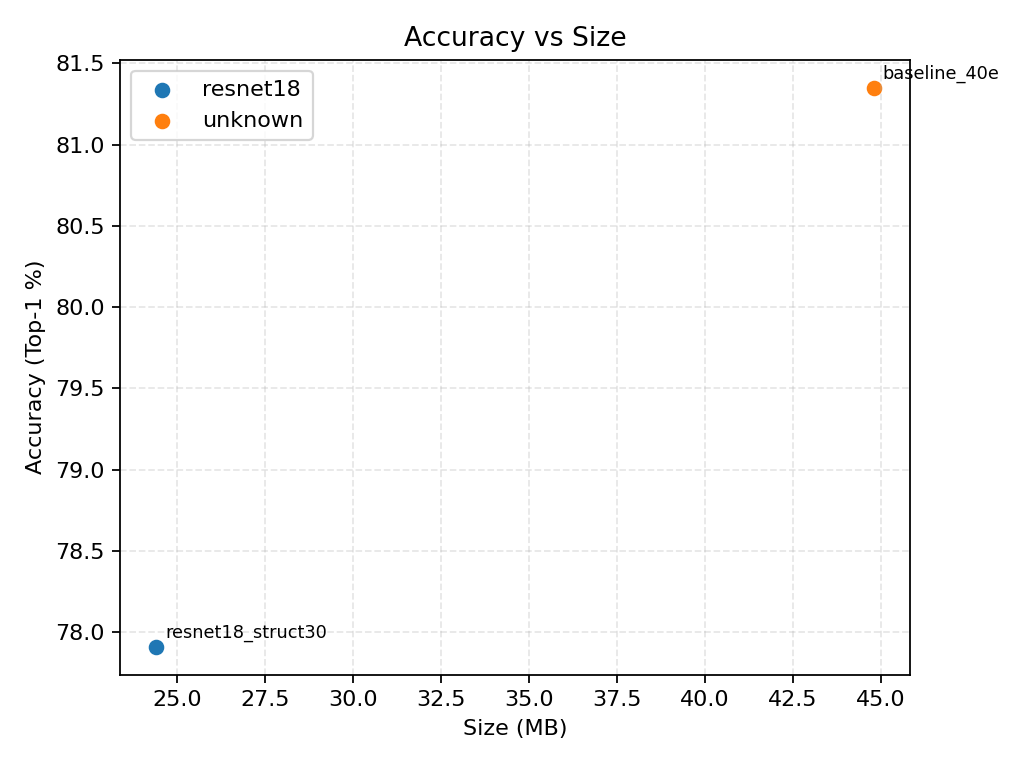

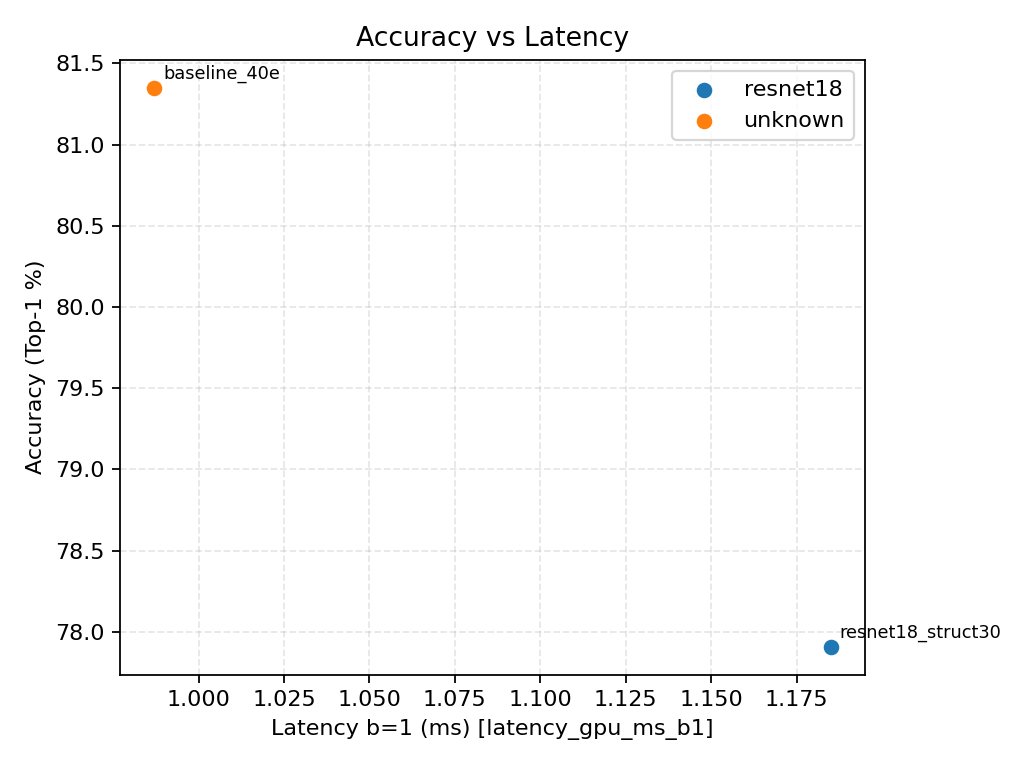

In [30]:
from pathlib import Path
import pandas as pd
from IPython.display import display, Image

csv_path   = Path("outputs/results.csv")
plot_size  = Path("outputs/plot_acc_vs_size.png")
plot_lat   = Path("outputs/plot_acc_vs_latency.png")

assert csv_path.exists(), "results.csv not found — run the cell above first."

df = pd.read_csv(csv_path)
# Put useful columns first if present
preferred = [c for c in [
    "model","variant","run","device",
    "acc_top1","latency_ms_b1","model_size_mb","params_millions",
    "dataset","epochs","batch_size","sparsity_percent"
] if c in df.columns]
df = df[preferred + [c for c in df.columns if c not in preferred]].copy()

# Neat formatting if numeric cols exist
fmt = {}
for c in ["acc_top1","latency_ms_b1","model_size_mb","params_millions","sparsity_percent"]:
    if c in df.columns:
        fmt[c] = "{:.3f}" if c != "acc_top1" else "{:.2f}"

print(f"[SUMMARY] rows={len(df)}  cols={len(df.columns)}")
display(df.style.format(fmt).set_properties(**{"text-align":"left"}))

# Display plots if present
if plot_size.exists():
    display(Image(filename=str(plot_size)))
else:
    print("[WARN] plot_acc_vs_size.png not found.")

if plot_lat.exists():
    display(Image(filename=str(plot_lat)))
else:
    print("[WARN] plot_acc_vs_latency.png not found.")


In [32]:
import pandas as pd

# If you still have `df` from earlier, we reuse it. Otherwise, load it:
if "df" not in globals():
    df = pd.read_csv("outputs/results.csv")

def pick_col(df, candidates):
    """Return the first column name that exists in df from the candidates list (or None)."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Try common aliases written by different scripts
COL_MODEL   = pick_col(df, ["model"])
COL_VAR     = pick_col(df, ["variant", "run", "tag"])
COL_DEVICE  = pick_col(df, ["device", "bench_device"])
COL_ACC     = pick_col(df, ["acc_top1", "accuracy", "top1"])
COL_SIZE    = pick_col(df, ["model_size_mb", "size_mb", "checkpoint_size_mb", "artifact_size_mb"])
COL_LAT     = pick_col(df, ["latency_ms_b1", "latency_ms", "avg_latency_ms", "latency_ms_per_sample"])

print("[COLUMNS FOUND]", sorted(df.columns))
print({
    "model": COL_MODEL, "variant": COL_VAR, "device": COL_DEVICE,
    "acc": COL_ACC, "size_mb": COL_SIZE, "latency_ms": COL_LAT
})

# Build a safe view with whatever we have
cols_for_view = [c for c in [COL_MODEL, COL_VAR, COL_DEVICE, COL_ACC, COL_SIZE, COL_LAT] if c]
view = df[cols_for_view].copy()

# Pretty formatting
fmt = {}
if COL_ACC:  fmt[COL_ACC]  = "{:.2f}"
if COL_LAT:  fmt[COL_LAT]  = "{:.3f}"
if COL_SIZE: fmt[COL_SIZE] = "{:.3f}"

# Show the table
print(f"[SUMMARY] rows={len(view)}  cols={len(view.columns)}")
display(view.style.format(fmt).set_properties(**{"text-align":"left"}))

# Highlights (only if the needed columns exist)
def top_k(d, key, asc, where=None, k=3):
    sub = d if where is None else d.query(where)
    if key and (key in sub.columns) and not sub.empty:
        return sub.dropna(subset=[key]).sort_values(key, ascending=asc).head(k)
    return None

print("\n[HIGHLIGHTS]")

if COL_ACC:
    best_acc = top_k(df, COL_ACC, asc=False, k=3)
    if best_acc is not None:
        print("- Top accuracy:")
        display(best_acc[[c for c in [COL_MODEL,COL_VAR,COL_DEVICE,COL_ACC,COL_SIZE,COL_LAT] if c]].style.format(fmt))

if COL_LAT and COL_DEVICE:
    # CPU fastest (threads=1 in our benches)
    best_cpu = top_k(df, COL_LAT, asc=True, where=f"{COL_DEVICE}=='cpu'", k=3)
    if best_cpu is not None and not best_cpu.empty:
        print("- Fastest CPU latency:")
        display(best_cpu[[c for c in [COL_MODEL,COL_VAR,COL_DEVICE,COL_ACC,COL_SIZE,COL_LAT] if c]].style.format(fmt))

    # GPU fastest
    best_gpu = top_k(df, COL_LAT, asc=True, where=f"{COL_DEVICE}=='cuda' or {COL_DEVICE}=='gpu'", k=3)
    if best_gpu is not None and not best_gpu.empty:
        print("- Fastest GPU latency:")
        display(best_gpu[[c for c in [COL_MODEL,COL_VAR,COL_DEVICE,COL_ACC,COL_SIZE,COL_LAT] if c]].style.format(fmt))

# If some metrics were missing, give a gentle hint
missing = []
if not COL_SIZE: missing.append("model size (MB)")
if not COL_LAT:  missing.append("latency (ms)")
if missing:
    print(f"\n[NOTE] Your CSV lacks: {', '.join(missing)}. "
          f"That’s OK — some scripts don’t log those fields. "
          f"If you want them, re-run benches and summarization.")


[COLUMNS FOUND] ['acc_top1', 'device', 'git_commit', 'latency_cpu_ms_b1', 'latency_gpu_ms_b1', 'model', 'params_millions', 'size_mb', 'torch', 'variant']
{'model': 'model', 'variant': 'variant', 'device': 'device', 'acc': 'acc_top1', 'size_mb': 'size_mb', 'latency_ms': None}
[SUMMARY] rows=2  cols=5


,model,variant,device,acc_top1,size_mb
0,unknown,baseline_40e,cuda,81.35,44.799
1,resnet18,resnet18_struct30,cuda,77.91,24.416



[HIGHLIGHTS]
- Top accuracy:


,model,variant,device,acc_top1,size_mb
0,unknown,baseline_40e,cuda,81.35,44.799
1,resnet18,resnet18_struct30,cuda,77.91,24.416



[NOTE] Your CSV lacks: latency (ms). That’s OK — some scripts don’t log those fields. If you want them, re-run benches and summarization.


✅ CSV & plots created.

**Interpretation checklist**
- Does the **pruned TorchScript** point fall **left** (smaller size) and **down** (lower latency) with only a modest drop in **accuracy**?
- Do results look **consistent** with earlier individual benches?
- Note any outliers (e.g., runs with odd latency or missing metadata) — consider re-running those steps.

Next: **Section 8 — Bias–variance sanity (learning-curves on small/large subsets)** to demonstrate that we understand generalization, not just compression.


# Section 8 — Export compact showcase bundle (zip)

**Goal:** Create a single ZIP file you can share with a recruiter containing:
- `README.md` (project overview)
- `outputs/results.csv` (all metrics)
- `outputs/plot_acc_vs_size.png`
- `outputs/plot_acc_vs_latency.png`
- `runs/<baseline>/best.pt` (baseline weights)
- `runs/<pruned>/structured.ts` (TorchScript of pruned model)
- `scripts/run_full_pipeline.ps1` (one-click pipeline)
- `scripts/clean_repo.ps1` (tidy script)

This mirrors the PowerShell step but works cross-platform inside the notebook:
- It **auto-discovers** `<baseline>` and `<pruned>` if you don’t set them.
- It **skips missing files** and logs what was included.
- It prints a short **manifest** and bundle size when done.


In [33]:
from pathlib import Path
import zipfile, os, time

# Optional: set these if you want to override auto-discovery
OutBase = None          # e.g., "baseline_40e"
PrunedName = None       # e.g., "resnet18_struct30"

root = Path(".").resolve()
outs = root / "outputs"
runs = root / "runs"
scripts = root / "scripts"
readme = root / "README.md"

def newest_file(patterns):
    """Return newest Path among all matches for given glob patterns."""
    candidates = []
    for pat in patterns:
        for p in root.glob(pat):
            try:
                candidates.append((p.stat().st_mtime, p))
            except FileNotFoundError:
                pass
    if not candidates:
        return None
    return sorted(candidates, key=lambda t: t[0], reverse=True)[0][1]

# --- Auto-discover baseline best.pt if not provided ---
if OutBase is None:
    newest_best = newest_file(["runs/*/best.pt", "runs/*/best.pth"])
    if newest_best:
        OutBase = newest_best.parent.name

# --- Auto-discover pruned TorchScript if not provided ---
if PrunedName is None:
    newest_ts = newest_file(["runs/*/structured.ts"])
    if newest_ts:
        PrunedName = newest_ts.parent.name

print({"OutBase": OutBase, "PrunedName": PrunedName})

# Build include list (skip anything missing)
candidates = [
    readme,
    outs / "results.csv",
    outs / "plot_acc_vs_size.png",
    outs / "plot_acc_vs_latency.png",
    runs / (OutBase or "") / "best.pt" if OutBase else None,
    runs / (PrunedName or "") / "structured.ts" if PrunedName else None,
    scripts / "run_full_pipeline.ps1",
    scripts / "clean_repo.ps1",
]

include = [p for p in candidates if p and p.exists()]
missing = [p for p in candidates if p and not p.exists()]

bundle = root / "showcase_bundle.zip"
if bundle.exists():
    bundle.unlink()

# Write the zip (store with relative paths)
with zipfile.ZipFile(bundle, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in include:
        arc = p.relative_to(root)
        zf.write(p, arcname=str(arc))

# Report
total_bytes = sum(p.stat().st_size for p in include if p.exists())
print(f"[OK] Wrote {bundle}  ({total_bytes/1024/1024:.2f} MB)")
print("\n[INCLUDED]")
for p in include:
    size = p.stat().st_size if p.exists() else 0
    print(f"  - {p.relative_to(root)}  ({size/1024:.1f} KB)")
if missing:
    print("\n[SKIPPED - missing]")
    for p in missing:
        print(f"  - {p.relative_to(root)}")


{'OutBase': 'resnet18_struct30', 'PrunedName': 'resnet18_struct30'}
[OK] Wrote C:\Users\khal6952\Documents\GitHub\compact-ml-bench\showcase_bundle.zip  (46.77 MB)

[INCLUDED]
  - README.md  (0.6 KB)
  - outputs\results.csv  (0.5 KB)
  - outputs\plot_acc_vs_size.png  (54.2 KB)
  - outputs\plot_acc_vs_latency.png  (59.2 KB)
  - runs\resnet18_struct30\best.pt  (23843.3 KB)
  - runs\resnet18_struct30\structured.ts  (23932.1 KB)
  - scripts\clean_repo.ps1  (1.3 KB)

[SKIPPED - missing]
  - scripts\run_full_pipeline.ps1


# Section 9 — Optional: Launch Streamlit demo

**Goal:** Start a small Streamlit app that loads:
- the **baseline** checkpoint (`runs/<baseline>/best.pt`)
- the **structured-pruned TorchScript** model (`runs/<pruned>/structured.ts`)

The app shows sample predictions and simple latency readouts.  
This runs as a local web app at **http://localhost:8501** (opens in your browser).  
> Note: Jupyter can’t embed Streamlit directly; we spawn it as a separate process.

**Requirements**
- `demo_app.py` present in repo root.
- `streamlit` installed in this virtual environment.

The cell below:
1) Auto-discovers your latest baseline/pruned runs (or you can override).
2) Installs `streamlit` if missing.
3) Starts the app and prints the local URL.
4) Saves a handle in `STREAMLIT_PROC` so you can stop it later.


In [34]:
import sys, subprocess, shutil, time, os
from pathlib import Path

# --- You may optionally override these (otherwise auto-discovered) ---
OutBase = None      # e.g. "baseline_40e"
PrunedName = None   # e.g. "resnet18_struct30"
# --------------------------------------------------------------------

root = Path(".").resolve()
runs = root / "runs"
demo_script = root / "demo_app.py"

def newest_file(globs):
    cand = []
    for g in globs:
        for p in root.glob(g):
            try:
                cand.append((p.stat().st_mtime, p))
            except FileNotFoundError:
                pass
    return sorted(cand, key=lambda t: t[0], reverse=True)[0][1] if cand else None

# Auto-detect baseline + pruned if not set
if OutBase is None:
    best = newest_file(["runs/*/best.pt", "runs/*/best.pth"])
    OutBase = best.parent.name if best else None

if PrunedName is None:
    ts = newest_file(["runs/*/structured.ts"])
    PrunedName = ts.parent.name if ts else None

print({"OutBase": OutBase, "PrunedName": PrunedName})

# Resolve artifact paths
ckpt = runs / (OutBase or "") / "best.pt" if OutBase else None
ts   = runs / (PrunedName or "") / "structured.ts" if PrunedName else None

# Basic validations
problems = []
if not demo_script.exists():
    problems.append("demo_app.py not found at repo root.")
if not ckpt or not ckpt.exists():
    problems.append(f"Baseline checkpoint missing: {ckpt}")
if not ts or not ts.exists():
    problems.append(f"Pruned TorchScript missing: {ts}")

if problems:
    print("[STREAMLIT] Cannot launch due to:")
    for p in problems:
        print(" -", p)
    print("Fix the above and re-run this cell.")
else:
    # Ensure streamlit available (install if missing)
    if not shutil.which("streamlit"):
        print("[STREAMLIT] Installing streamlit in this environment...")
        rc = subprocess.call([sys.executable, "-m", "pip", "install", "streamlit"])
        if rc != 0:
            raise RuntimeError("pip install streamlit failed")
    url = "http://localhost:8501"
    cmd = [
        "streamlit", "run", str(demo_script),
        "--server.headless=true",
        "--server.port=8501",
        "--",
        "--checkpoint", str(ckpt),
        "--ts", str(ts),
    ]
    print("[STREAMLIT] Command:\n ", " ".join(cmd))
    print(f"[STREAMLIT] Starting… then open: {url}")
    # Launch detached so the notebook remains responsive
    STREAMLIT_PROC = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    time.sleep(1.5)
    # Print a few lines from the streamlit log to confirm it's alive
    for _ in range(8):
        line = STREAMLIT_PROC.stdout.readline()
        if not line:
            break
        print("[streamlit]", line.rstrip())
    print("\n[STREAMLIT] Running. Visit:", url)
    print("To stop: run the cell below to terminate the process.")



{'OutBase': 'resnet18_struct30', 'PrunedName': 'resnet18_struct30'}
[STREAMLIT] Cannot launch due to:
 - demo_app.py not found at repo root.
Fix the above and re-run this cell.


In [35]:
try:
    STREAMLIT_PROC.terminate()
    STREAMLIT_PROC.wait(timeout=5)
    print("[STREAMLIT] Stopped.")
except NameError:
    print("No STREAMLIT_PROC found in this notebook session.")
except Exception as e:
    print("Stop error:", e)


No STREAMLIT_PROC found in this notebook session.


# Section 10 — Finish ✅

You now have:
- **Results** and plots in `outputs/`
- **Artifacts** (baseline `best.pt`, pruned `structured.ts`) in `runs/`
- **Bundle** zip for easy sharing (created in Section 8)
- (Optional) **Streamlit demo** running at http://localhost:8501

This completes the end-to-end project showcase.


In [36]:
from pathlib import Path
root = Path(".")
have = [p for p in [
    root/"outputs/results.csv",
    root/"outputs/plot_acc_vs_size.png",
    root/"outputs/plot_acc_vs_latency.png",
    root/"showcase_bundle.zip"
] if p.exists()]
print("[DONE] Found", len(have), "key outputs:")
for p in have:
    print(" -", p, f"({p.stat().st_size/1024:.1f} KB)")


[DONE] Found 4 key outputs:
 - outputs\results.csv (0.5 KB)
 - outputs\plot_acc_vs_size.png (54.2 KB)
 - outputs\plot_acc_vs_latency.png (59.2 KB)
 - showcase_bundle.zip (44291.9 KB)
